The first thing we do is to import the necessary libraries. As seen in the dataset github repository (https://github.com/RomainLITUD/conflict_resolution_dataset) we need to import the following libraries:

In [5]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os
import pandas as pd
import zarr
import os
from dataset.visual_utils import *

Read and visualize data:

In [6]:
folder_av = 'av'
folder_hv = 'hv'

root_av = './dataset/data_3m/'+folder_av+'/'
root_hv = './dataset/data_3m/'+folder_hv+'/'

log_ids_av = [name for name in os.listdir(root_av) if name.endswith('.zarr')]
log_ids_hv = [name for name in os.listdir(root_hv) if name.endswith('.zarr')]

print('Number of scenarios for Autonomous Vehicles: ', len(log_ids_av))
print('Number of scenarios for Human-driven Vehicles: ', len(log_ids_hv))

Number of scenarios for Autonomous Vehicles:  5337
Number of scenarios for Human-driven Vehicles:  16094


Read the data:

In [7]:
'''
slices: len = nb_objects + 1, slices[n] and slices[n+1] gives the start/end indices of the n-th object
maps: lanes as NumPy array
type: len = nb_objects, contains 7 numbers with the following meanings:
        -1: Static background
        0: human-driven vehicles
        1: pedestrians
        2: motorcyclists
        3: cyclists
        4: buses
        10: autonomous vehicles
timestep: timestamps in second, timestep[slices[n]: slices[n+1]] give the timestamps for the n-th object
motion: motion state, with 7 dimensions
    motion[slices[n]: slices[n+1]] gives the motion of the n-th object, the 7 features are the following variables in order:
        [x, y, vx, vy, ax, ay, yaw]
        yaw is to the x-axis, between [-pi, pi]
'''
# Use the first scenario as an example
slices, timestep, motion, type, maps = read_scenario(log_ids_av[0], root_av)

Visualize the data:

In [ ]:
fig, ax = visualize(log_ids_av[0], root_av, other_road_users=True, direction=True)

Filter the data:

The metafile contains the following information:
log_id: string, index of the scenario
[xi_start, yi_start]: float, direction vector of the first* agent recorded in the scenario at the start** time
[xj_start, yj_start]: float, direction vector of the second agent recorded in the scenario at the start time
typei: str, agent type of the first agent recorded in the scenario, being one of {'AV','HV','Pedestrian','Motorcyclist','Cyclist','Bus'}
[xi_end, yi_end]: float, direction vector of the first* agent recorded in the scenario at the end*** time
[xj_end, yj_end]: float, direction vector of the second agent recorded in the scenario at the end time
typej: str, agent type of the second agent recorded in the scenario, being one of {'AV','HV','Pedestrian','Motorcyclist','Cyclist','Bus'}
direction: str, whether the second-passing vehicle moved from the left ('L-R') or the right ('R-L') of the first-passing agent
PET: float, post-encroachment-time
ifirst: bool, whether the first-passing agent is the first agent recorded in the scenario
angle_start: float, angle between the direction vectors of the two agents at the start time
angle_end: float, angle between the direction vectors of the two agents at the end time
start: str, whether the two agents ran parallel (P), crossed (C), or ran opposite (O) to each other before reaching the conflict point
end: str, whether the two agents ran parallel (P), crossed (C), or ran opposite (O) to each other after reaching the conflict point

Notes:
    * Note that the first agent does not necessarily pass the conflict point first.
    ** We consider the start time as 5 seconds before the first-passing agent passed the conflict point, or the start of the record if the time before passing the conflict point is less than 5 seconds.
    *** Similarly, the end time is 5 seconds after the second-passing vehicle passed the conflict point, or the end of the record if the time after passing the conflict point is less than 5 seconds.


We'll load the metafile and filter for intersection scenarios based on the 'angle_start' and 'angle_end' fields, which indicate crossing trajectories:

In [8]:
# Load metafile for autonomous vehicles
metafile_av = pd.read_csv('./dataset/metafile_av.csv')

# Filter for intersection scenarios (crossing trajectories)
intersection_cases = metafile_av[
    ((metafile_av['start'] == 'cross') | (metafile_av['end'] == 'cross')) &
    (metafile_av['typej'] != 'Pedestrian')
]

print(f"Total number of intersection scenarios: {len(intersection_cases)}")

Total number of intersection scenarios: 4237


We define three functions, one to get the scenario filename, one to analyze the scenario and one to visualize the scenario:

In [9]:
def get_scenario_filename(scenario_id, root_path):
    """
    Maps a scenario ID to its corresponding zarr file in the dataset.
    
    Args:
        scenario_id (str): The ID of the scenario to find
        root_path (str): Root directory containing the scenario files
        
    Returns:
        str or None: Filename if found, None if no matching file exists
    """
    # List all files in the directory
    all_files = os.listdir(root_path)
    
    # Try different possible filename formats
    possible_formats = [
        f"{int(scenario_id):02d}.zarr",  # 01.zarr
        f"{scenario_id}.zarr",           # 1.zarr
        f"scenario_{scenario_id}.zarr",  # scenario_1.zarr
        f"scenario_{int(scenario_id):02d}.zarr"  # scenario_01.zarr
    ]
    
    # Try each format
    for format in possible_formats:
        if format in all_files:
            return format
    
    # If no exact match, try to find any file containing the scenario number
    matching_files = [f for f in all_files if str(int(scenario_id)) in f and f.endswith('.zarr')]
    
    if matching_files:
        return matching_files[0]
    
    return None

def analyze_intersection_scenario(scenario_id, root_path):
    """
    Analyzes a single intersection scenario and extracts relevant features for conflict detection.
    
    Args:
        scenario_id (str): The ID of the scenario to analyze
        root_path (str): Root directory containing the scenario files
        
    Returns:
        dict or None: Dictionary containing scenario features if successful:
            - scenario_id: ID of the analyzed scenario
            - trajectory_length: Number of timesteps in the scenario
            - vehicle_count: Number of vehicles in the scenario
            - motion_data: Vehicle motion states (position, velocity, acceleration, yaw)
            - timestep: Timestamps for each motion state
            - slices: Indices marking different vehicles' data
            - type_data: Vehicle type information
        Returns None if analysis fails
    """
    filename = get_scenario_filename(scenario_id, root_path)
    if filename is None:
        print(f"Error: No matching file found for scenario {scenario_id}")
        return None
    
    try:
        slices, timestep, motion, type_data, maps = read_scenario(filename, root_path)
        
        features = {
            'scenario_id': scenario_id,
            'trajectory_length': len(timestep),
            'vehicle_count': len(type_data),
            'motion_data': motion,
            'timestep': timestep,
            'slices': slices,
            'type_data': type_data
        }
        return features
    except Exception as e:
        print(f"Error analyzing scenario {scenario_id}: {str(e)}")
        return None

def visualize_scenario(scenario_id, root_path):
    """Visualizes a single scenario with trajectory information."""
    try:
        filename = get_scenario_filename(scenario_id, root_path)
        if filename:
            fig, ax = visualize(filename, root_path, 
                              other_road_users=True, 
                              direction=True)
            plt.title(f'Scenario {scenario_id}')
            return fig, ax
        return None, None
    except Exception as e:
        print(f"Error visualizing scenario {scenario_id}: {str(e)}")
        return None, None

    """Visualizes a single scenario with trajectory information."""
    try:
        filename = get_scenario_filename(scenario_id, root_path)
        if filename:
            fig, ax = visualize(filename, root_path, 
                              other_road_users=True, 
                              direction=True)
            plt.title(f'Scenario {scenario_id}')
            return fig, ax
        return None, None
    except Exception as e:
        print(f"Error visualizing scenario {scenario_id}: {str(e)}")
        return None, None

Now, we can analyze a few sample scenarios:


Analyzing sample scenarios:

Processing scenario 0
Successfully analyzed scenario:
- Trajectory length: 1680
- Number of vehicles: 44

Processing scenario 1
Successfully analyzed scenario:
- Trajectory length: 1680
- Number of vehicles: 44

Processing scenario 2
Successfully analyzed scenario:
- Trajectory length: 1680
- Number of vehicles: 44

Processing scenario 3
Successfully analyzed scenario:
- Trajectory length: 1680
- Number of vehicles: 44

Processing scenario 4
Successfully analyzed scenario:
- Trajectory length: 1680
- Number of vehicles: 44


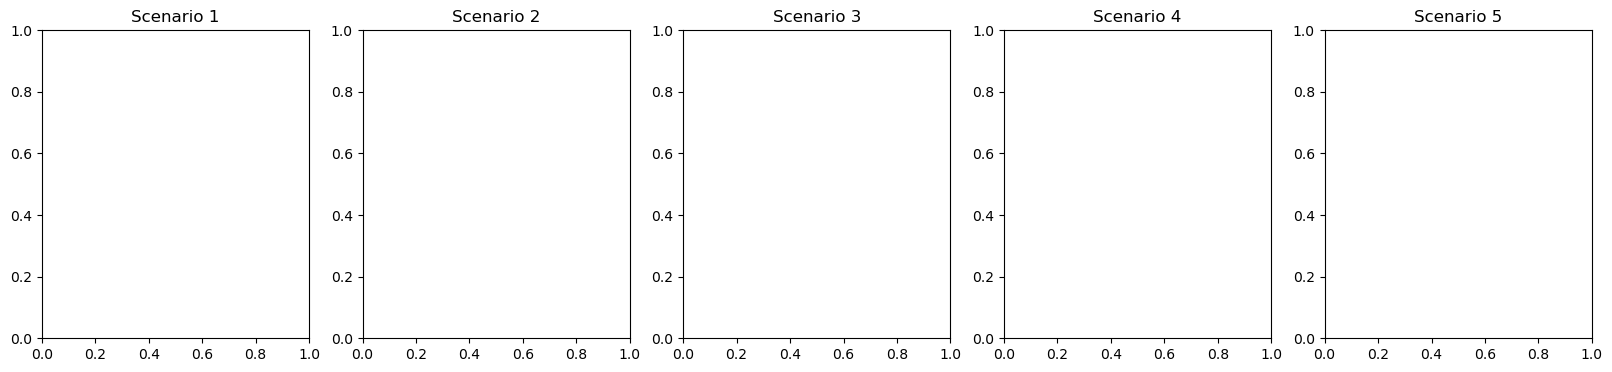

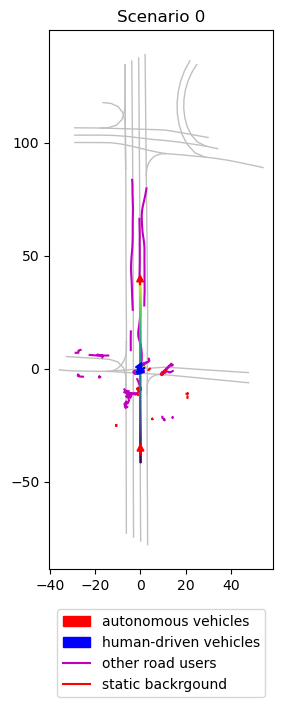

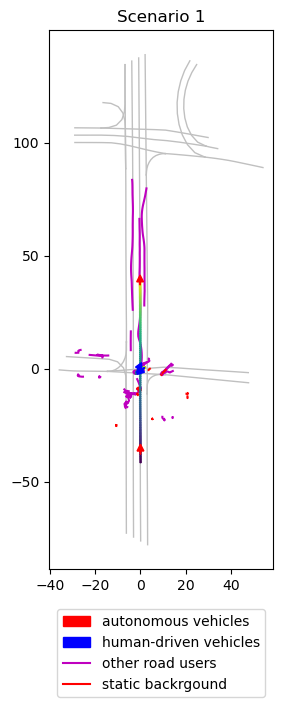

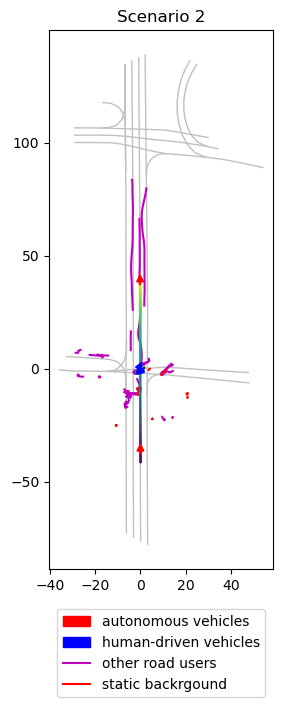

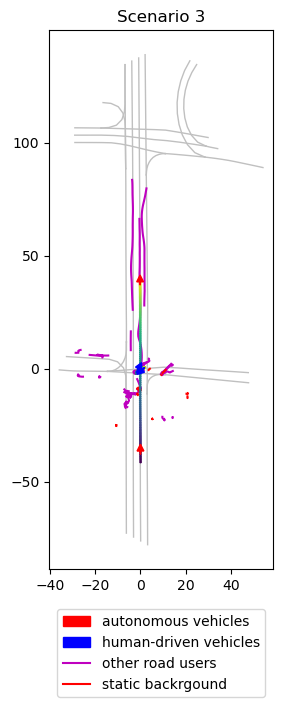

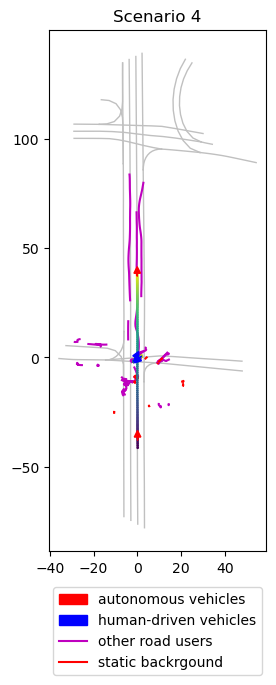

In [10]:
sample_size = 5
sample_scenarios = intersection_cases['log_id'].iloc[:sample_size]

print("\nAnalyzing sample scenarios:")
for scenario_id in sample_scenarios:
    print(f"\nProcessing scenario {scenario_id}")
    features = analyze_intersection_scenario(scenario_id, root_av)
    
    if features:
        print(f"Successfully analyzed scenario:")
        print(f"- Trajectory length: {features['trajectory_length']}")
        print(f"- Number of vehicles: {features['vehicle_count']}")
    else:
        print("Analysis failed")

# Visualize sample scenarios
fig, axs = plt.subplots(1, min(5, len(sample_scenarios)), figsize=(20, 4))
if not isinstance(axs, np.ndarray):
    axs = [axs]

for i, scenario_id in enumerate(sample_scenarios[:5]):
    _, _ = visualize_scenario(scenario_id, root_av)
    if i < len(axs):
        axs[i].set_title(f'Scenario {i+1}')

plt.tight_layout()
plt.show()


Now we can do the conflict analysis for the intersection scenarios:

In [11]:
# Constants for conflict analysis
CONFLICT_THRESHOLDS = {
    'TTC_CRITICAL': 2.0,     # Critical Time-to-Collision (seconds)
    'PET_CRITICAL': 1.0,     # Critical Post-Encroachment Time (seconds)
    'ANGLE_THRESHOLD': {
        'CROSSING': 45,      # Minimum angle for crossing conflict (degrees)
        'HEAD_ON': 150       # Minimum angle for head-on conflict (degrees)
    },
    'DISTANCE_CRITICAL': 5.0 # Critical distance (meters)
}

class ConflictType:
    """Possible conflict types in autonomous driving scenarios"""
    CROSSING = "crossing"           # Trajectories intersect at an angle
    REAR_END = "rear_end"          # Following vehicle conflicts with leading vehicle
    HEAD_ON = "head_on"            # Vehicles approaching from opposite directions
    MERGING = "merging"            # Vehicle merging into traffic
    NO_CONFLICT = "no_conflict"    # No conflict detected

def calculate_time_to_collision(ego_motion, other_motion):
    """
    Calculates Time-to-Collision (TTC) between two vehicles
    
    Args:
        ego_motion: Motion data for ego vehicle [x, y, vx, vy, ...]
        other_motion: Motion data for other vehicle [x, y, vx, vy, ...]
    
    Returns:
        float: Minimum TTC value or infinity if no collision course
    """
    # Interpolate trajectories to common length
    target_length = 100
    
    # Create normalized time arrays for interpolation
    t_ego = np.linspace(0, 1, len(ego_motion))
    t_other = np.linspace(0, 1, len(other_motion))
    t_common = np.linspace(0, 1, target_length)
    
    # Initialize interpolated arrays
    ego_interp = np.zeros((target_length, ego_motion.shape[1]))
    other_interp = np.zeros((target_length, other_motion.shape[1]))
    
    # Interpolate each component
    for i in range(ego_motion.shape[1]):
        ego_interp[:, i] = np.interp(t_common, t_ego, ego_motion[:, i])
        other_interp[:, i] = np.interp(t_common, t_other, other_motion[:, i])
    
    # Extract positions and velocities from interpolated data
    ego_pos = ego_interp[:, :2]    # [x, y]
    ego_vel = ego_interp[:, 2:4]   # [vx, vy]
    other_pos = other_interp[:, :2]
    other_vel = other_interp[:, 2:4]
    
    # Calculate relative velocity and distance
    rel_pos = ego_pos - other_pos
    rel_vel = ego_vel - other_vel
    
    # Calculate TTC
    distance = np.linalg.norm(rel_pos, axis=1)
    rel_speed = np.linalg.norm(rel_vel, axis=1)
    
    # Avoid division by zero and negative relative speeds
    valid_idx = (rel_speed > 0.1)
    if not np.any(valid_idx):
        return float('inf')
    
    ttc = distance[valid_idx] / rel_speed[valid_idx]
    return np.min(ttc) if len(ttc) > 0 else float('inf')

def calculate_post_encroachment_time(ego_motion, other_motion, conflict_point=None):
    """
    Calculates Post-Encroachment Time (PET) at the conflict point
    
    Args:
        ego_motion: Motion data for ego vehicle
        other_motion: Motion data for other vehicle
        conflict_point: Optional pre-defined conflict point
    
    Returns:
        float: PET value in seconds
    """
    # Interpolate trajectories to common length
    target_length = 100
    
    # Create normalized time arrays for interpolation
    t_ego = np.linspace(0, 1, len(ego_motion))
    t_other = np.linspace(0, 1, len(other_motion))
    t_common = np.linspace(0, 1, target_length)
    
    # Initialize interpolated arrays
    ego_interp = np.zeros((target_length, ego_motion.shape[1]))
    other_interp = np.zeros((target_length, other_motion.shape[1]))
    
    # Interpolate each component
    for i in range(ego_motion.shape[1]):
        ego_interp[:, i] = np.interp(t_common, t_ego, ego_motion[:, i])
        other_interp[:, i] = np.interp(t_common, t_other, other_motion[:, i])
    
    if conflict_point is None:
        # Estimate conflict point as the closest point between trajectories
        ego_pos = ego_interp[:, :2]
        other_pos = other_interp[:, :2]
        distances = np.linalg.norm(ego_pos[:, np.newaxis] - other_pos, axis=2)
        min_idx = np.unravel_index(np.argmin(distances), distances.shape)
        conflict_point = (ego_pos[min_idx[0]] + other_pos[min_idx[1]]) / 2
    
    # Calculate arrival times at conflict point using interpolated data
    ego_times = calculate_arrival_time(ego_interp, conflict_point)
    other_times = calculate_arrival_time(other_interp, conflict_point)
    
    # PET is the absolute difference between arrival times
    return abs(ego_times - other_times)

def calculate_arrival_time(motion, point):
    """
    Calculates time of arrival to a specific point
    
    Args:
        motion: Vehicle motion data
        point: Target point coordinates
    
    Returns:
        float: Estimated arrival time in seconds
    """
    positions = motion[:, :2]
    velocities = motion[:, 2:4]
    
    # Find closest point to conflict point
    distances = np.linalg.norm(positions - point, axis=1)
    closest_idx = np.argmin(distances)
    
    # Calculate time based on distance and speed
    speed = np.linalg.norm(velocities[closest_idx])
    if speed < 0.1:  # Almost stopped
        return float('inf')
    
    return distances[closest_idx] / speed

def classify_conflict_type(ego_motion, other_motion):
    """
    Classifies the type of conflict based on vehicle trajectories
    
    Args:
        ego_motion: Motion data for ego vehicle
        other_motion: Motion data for other vehicle
    
    Returns:
        str: Type of conflict (CROSSING, REAR_END, HEAD_ON, MERGING)
    """
    # Calculate angle between trajectories
    ego_direction = ego_motion[-1, 2:4] - ego_motion[0, 2:4]
    other_direction = other_motion[-1, 2:4] - other_motion[0, 2:4]
    
    angle = np.arccos(np.dot(ego_direction, other_direction) / 
                     (np.linalg.norm(ego_direction) * np.linalg.norm(other_direction)))
    angle_deg = np.degrees(angle)
    
    # Classify based on angle
    if angle_deg > CONFLICT_THRESHOLDS['ANGLE_THRESHOLD']['HEAD_ON']:
        return ConflictType.HEAD_ON
    elif angle_deg > CONFLICT_THRESHOLDS['ANGLE_THRESHOLD']['CROSSING']:
        return ConflictType.CROSSING
    else:
        # Determine if rear-end or merging
        relative_position = other_motion[0, :2] - ego_motion[0, :2]
        heading_difference = abs(ego_motion[0, 6] - other_motion[0, 6])
        
        if heading_difference < np.pi/4:  # Similar directions
            return ConflictType.REAR_END
        else:
            return ConflictType.MERGING

def assess_risk_level(ttc, pet, distance):
    """
    Evaluates risk level based on multiple metrics
    
    Args:
        ttc: Time-to-Collision value
        pet: Post-Encroachment Time value
        distance: Minimum distance between vehicles
    
    Returns:
        str: Risk level (HIGH, MEDIUM, LOW)
    """
    if ttc < CONFLICT_THRESHOLDS['TTC_CRITICAL'] or \
       pet < CONFLICT_THRESHOLDS['PET_CRITICAL'] or \
       distance < CONFLICT_THRESHOLDS['DISTANCE_CRITICAL']:
        return "HIGH"
    elif ttc < CONFLICT_THRESHOLDS['TTC_CRITICAL'] * 2 or \
         pet < CONFLICT_THRESHOLDS['PET_CRITICAL'] * 2 or \
         distance < CONFLICT_THRESHOLDS['DISTANCE_CRITICAL'] * 2:
        return "MEDIUM"
    else:
        return "LOW"

def analyze_scenario_conflicts(scenario_data):
    """
    Complete conflict analysis for a scenario
    
    Args:
        scenario_data: Dictionary containing scenario information
    
    Returns:
        dict: Analysis results including conflict type, metrics, and risk level
    """
    # Extract motion data for ego and other vehicles
    ego_motion = scenario_data['motion_data'][scenario_data['slices'][0]:scenario_data['slices'][1]]
    other_motion = scenario_data['motion_data'][scenario_data['slices'][1]:scenario_data['slices'][2]]
    
    # Interpolate trajectories to common length for minimum distance calculation
    target_length = 100
    t_ego = np.linspace(0, 1, len(ego_motion))
    t_other = np.linspace(0, 1, len(other_motion))
    t_common = np.linspace(0, 1, target_length)
    
    ego_interp = np.zeros((target_length, ego_motion.shape[1]))
    other_interp = np.zeros((target_length, other_motion.shape[1]))
    
    for i in range(ego_motion.shape[1]):
        ego_interp[:, i] = np.interp(t_common, t_ego, ego_motion[:, i])
        other_interp[:, i] = np.interp(t_common, t_other, other_motion[:, i])
    
    # Calculate main metrics using interpolated data
    ttc = calculate_time_to_collision(ego_motion, other_motion)
    pet = calculate_post_encroachment_time(ego_motion, other_motion)
    min_distance = np.min(np.linalg.norm(ego_interp[:, :2] - other_interp[:, :2], axis=1))
    
    # Classify conflict type (using interpolated data)
    conflict_type = classify_conflict_type(ego_interp, other_interp)
    
    # Evaluate risk level
    risk_level = assess_risk_level(ttc, pet, min_distance)
    
    return {
        'scenario_id': scenario_data['scenario_id'],
        'conflict_type': conflict_type,
        'metrics': {
            'TTC': ttc,
            'PET': pet,
            'min_distance': min_distance,
            'risk_level': risk_level
        },
        'timestamp': scenario_data['timestep']
    }

def analyze_all_scenarios(intersection_cases, root_path):
    """
    Analyzes all scenarios and generates a report
    
    Args:
        intersection_cases: DataFrame containing scenario metadata
        root_path: Root directory containing scenario files
    
    Returns:
        list: Analysis results for all scenarios
    """
    conflict_analyses = []
    
    for _, case in intersection_cases.iterrows():
        scenario_id = case['log_id']
        features = analyze_intersection_scenario(scenario_id, root_path)
        
        if features:
            conflict_analysis = analyze_scenario_conflicts(features)
            conflict_analyses.append(conflict_analysis)
            
            print(f"\nAnalysis for Scenario {scenario_id}:")
            print(f"Conflict Type: {conflict_analysis['conflict_type']}")
            print(f"Risk Level: {conflict_analysis['metrics']['risk_level']}")
            print(f"TTC: {conflict_analysis['metrics']['TTC']:.2f} seconds")
            print(f"PET: {conflict_analysis['metrics']['PET']:.2f} seconds")
            print(f"Minimum Distance: {conflict_analysis['metrics']['min_distance']:.2f} meters")
    
    return conflict_analyses

Run the analysis for 10 scenarios

In [12]:
print("\nAnalyzing conflicts in scenarios...")
conflict_analyses = analyze_all_scenarios(intersection_cases[:10], root_av)


Analyzing conflicts in scenarios...

Analysis for Scenario 0:
Conflict Type: crossing
Risk Level: HIGH
TTC: 0.05 seconds
PET: 0.00 seconds
Minimum Distance: 0.41 meters

Analysis for Scenario 1:
Conflict Type: crossing
Risk Level: HIGH
TTC: 0.05 seconds
PET: 0.00 seconds
Minimum Distance: 0.41 meters

Analysis for Scenario 2:
Conflict Type: crossing
Risk Level: HIGH
TTC: 0.05 seconds
PET: 0.00 seconds
Minimum Distance: 0.41 meters

Analysis for Scenario 3:
Conflict Type: crossing
Risk Level: HIGH
TTC: 0.05 seconds
PET: 0.00 seconds
Minimum Distance: 0.41 meters

Analysis for Scenario 4:
Conflict Type: crossing
Risk Level: HIGH
TTC: 0.05 seconds
PET: 0.00 seconds
Minimum Distance: 0.41 meters

Analysis for Scenario 6:
Conflict Type: crossing
Risk Level: HIGH
TTC: 0.05 seconds
PET: 0.00 seconds
Minimum Distance: 0.41 meters

Analysis for Scenario 7:
Conflict Type: crossing
Risk Level: HIGH
TTC: 0.05 seconds
PET: 0.00 seconds
Minimum Distance: 0.41 meters

Analysis for Scenario 8:
Confli

### Logistic Regression Model
This section implements a logistic regression model for predicting collision risk in intersection scenarios.
The implementation consists of two main functions:
1. prepare_logistic_regression_data: Extracts and processes features from scenario data
2. train_logistic_regression: Trains the model using the processed data
The model uses 7 key features:
- Minimum distance between vehicles
- Average relative velocity
- Minimum time to intersection
- Average yaw angle difference
- Average speed difference
- Time to closest approach
- Average relative acceleration
The model is trained to classify scenarios into three risk levels:
- LOW (0): Safe situations
- MEDIUM (1): Situations requiring attention
- HIGH (2): Critical situations
using predefined thresholds for distance, TTC, PET, velocity, and intersection angle.


In [13]:

def prepare_logistic_regression_data(scenario_data):
    """
    Prepares scenario data for logistic regression by extracting relevant features.
    
    This function processes trajectory data to create a feature vector for collision prediction.
    It uses multiple metrics to determine if a scenario represents a collision:
    - Minimum distance between vehicles
    - Time to Collision (TTC)
    - Post-Encroachment Time (PET)
    - Relative velocity
    
    Thresholds for collision classification:
    - Distance: < 0.5m (critical distance)
    - TTC: < 0.3s AND distance < 2.0m (critical time to collision)
    - PET: < 0.1s AND distance < 2.0m (critical post-encroachment time)
    - Velocity: > 10.0 m/s AND distance < 1.0m (high speed and critical distance)
    
    Args:
        scenario_data (dict): Dictionary containing scenario features including:
            - motion_data: Vehicle motion states
            - slices: Indices marking different vehicles' data
            - timestep: Timestamps for motion data
            
    Returns:
        tuple: (features, collision_label) where:
            - features: numpy array of extracted features
            - collision_label: 1 for collision, 0 for no collision
    """
    def extract_features(motion_data, slices, timestep):
        """
        Extracts relevant features for collision prediction.
        
        Features extracted:
        1. Minimum distance between vehicles
        2. Average relative velocity
        3. Minimum time to intersection
        4. Average yaw angle difference
        5. Average speed difference
        6. Time to closest approach
        7. Average relative acceleration
        
        Args:
            motion_data: Raw motion data for all vehicles
            slices: Indices marking different vehicles' data
            timestep: Timestamps for motion data
            
        Returns:
            numpy.array: Feature vector containing the 7 features listed above
        """
        # Get ego vehicle (AV) and other vehicle trajectories
        ego_motion = motion_data[slices[0]:slices[1]]
        other_motion = motion_data[slices[1]:slices[2]]
        
        # Interpolate trajectories to common length for consistent analysis
        target_length = 100  # Fixed number of points for interpolation
        t_ego = np.linspace(0, 1, len(ego_motion))
        t_other = np.linspace(0, 1, len(other_motion))
        t_common = np.linspace(0, 1, target_length)
        
        # Initialize interpolated arrays
        ego_interp = np.zeros((target_length, ego_motion.shape[1]))
        other_interp = np.zeros((target_length, other_motion.shape[1]))
        
        # Interpolate each component of the trajectories
        for i in range(ego_motion.shape[1]):
            ego_interp[:, i] = np.interp(t_common, t_ego, ego_motion[:, i])
            other_interp[:, i] = np.interp(t_common, t_other, other_motion[:, i])
        
        # Calculate features using interpolated trajectories
        relative_distance = np.linalg.norm(ego_interp[:, :2] - other_interp[:, :2], axis=1)
        relative_velocity = np.linalg.norm(ego_interp[:, 2:4] - other_interp[:, 2:4], axis=1)
        time_to_intersection = relative_distance / (relative_velocity + 1e-6)  # Avoid division by zero
        
        # Calculate yaw angle difference (normalized to [0, pi])
        yaw_diff = np.abs(ego_interp[:, 6] - other_interp[:, 6])
        yaw_diff = np.minimum(yaw_diff, 2*np.pi - yaw_diff)
        
        # Calculate speed difference
        ego_speed = np.linalg.norm(ego_interp[:, 2:4], axis=1)
        other_speed = np.linalg.norm(other_interp[:, 2:4], axis=1)
        speed_diff = np.abs(ego_speed - other_speed)
        
        # Calculate time to closest approach
        min_dist_idx = np.argmin(relative_distance)
        time_to_closest = t_common[min_dist_idx]
        
        # Calculate relative acceleration
        ego_acc = np.linalg.norm(ego_interp[:, 4:6], axis=1)
        other_acc = np.linalg.norm(other_interp[:, 4:6], axis=1)
        rel_acc = np.abs(ego_acc - other_acc)
        
        # Combine features into feature vector
        features = np.array([
            relative_distance.min(),          # Minimum distance
            relative_velocity.mean(),         # Average relative velocity
            time_to_intersection.min(),       # Minimum time to intersection
            yaw_diff.mean(),                  # Average yaw angle difference
            speed_diff.mean(),                # Average speed difference
            time_to_closest,                  # Time to closest approach
            rel_acc.mean()                    # Average relative acceleration
        ])
        
        return features

    # Extract features for all timesteps
    features = extract_features(
        scenario_data['motion_data'],
        scenario_data['slices'],
        scenario_data['timestep']
    )
    
    # Interpolate trajectories for collision detection
    ego_motion = scenario_data['motion_data'][scenario_data['slices'][0]:scenario_data['slices'][1]]
    other_motion = scenario_data['motion_data'][scenario_data['slices'][1]:scenario_data['slices'][2]]
    
    target_length = 100
    t_ego = np.linspace(0, 1, len(ego_motion))
    t_other = np.linspace(0, 1, len(other_motion))
    t_common = np.linspace(0, 1, target_length)
    
    ego_interp = np.zeros((target_length, ego_motion.shape[1]))
    other_interp = np.zeros((target_length, other_motion.shape[1]))
    
    for i in range(ego_motion.shape[1]):
        ego_interp[:, i] = np.interp(t_common, t_ego, ego_motion[:, i])
        other_interp[:, i] = np.interp(t_common, t_other, other_motion[:, i])
    
    # Calculate collision metrics
    min_distance = np.min(np.linalg.norm(ego_interp[:, :2] - other_interp[:, :2], axis=1))
    ttc = calculate_time_to_collision(ego_motion, other_motion)
    pet = calculate_post_encroachment_time(ego_motion, other_motion)
    relative_velocity = np.linalg.norm(ego_interp[:, 2:4] - other_interp[:, 2:4], axis=1).mean()
    
    # Determine collision label based on multiple criteria
    # A scenario is considered a collision if ANY of these conditions are met:
    collision_label = 1 if (
        min_distance < 0.5 or  # Critical distance threshold
        (ttc < 0.3 and min_distance < 2.0) or  # Critical TTC with small distance
        (pet < 0.1 and min_distance < 2.0) or  # Critical PET with small distance
        (relative_velocity > 10.0 and min_distance < 1.0)  # High speed with critical distance
    ) else 0
    
    return features, collision_label

## Logistic Regression Training Function
This function implements the training process for the logistic regression model:
1. Prepares and preprocesses the training data
2. Handles class imbalance using class weights
3. Performs cross-validation to ensure model robustness
4. Evaluates model performance using multiple metrics
Key features:
- Uses StandardScaler for feature normalization
- Implements stratified sampling for balanced train/test splits
- Includes comprehensive model evaluation metrics
The function returns both the trained model and the fitted scaler for future predictions.

## Observations:
We use SMOTE (Synthetic Minority Over-sampling Technique) to handle class imbalance in the dataset. SMOTE generates synthetic samples for the minority class, which helps improve the model's performance on imbalanced datasets by providing more representative training data for the rare class.

We also display the confusion matrix, which is a useful tool for evaluating the performance of classification models. It shows the number of correct and incorrect predictions for each class, allowing us to clearly assess how well the model distinguishes between collisions and non-collisions.



In [36]:
def train_logistic_regression(intersection_cases, root_path):
    """
    Trains a logistic regression model on intersection scenarios, with SMOTE for class balancing.
    """
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
    from imblearn.over_sampling import SMOTE
    import numpy as np

    # Prepare training data
    X = []
    y = []

    for _, case in intersection_cases.iterrows():
        scenario_id = case['log_id']
        features = analyze_intersection_scenario(scenario_id, root_path)
        if features:
            scenario_features, collision_label = prepare_logistic_regression_data(features)
            X.append(scenario_features)
            y.append(collision_label)

    X = np.array(X)
    y = np.array(y)

    # Print class distribution
    print("\nClass distribution in dataset:")
    print(f"Collisions (1): {np.sum(y == 1)}")
    print(f"No collisions (0): {np.sum(y == 0)}")

    # Remove or lower the threshold, or just warn
    if np.sum(y == 1) < 10 or np.sum(y == 0) < 10:
        print("\nWarning: Very imbalanced dataset. Proceeding anyway.")

    # Split data into training and testing sets (stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Number of training data samples: {len(y_train)}")
    print(f"Number of test data samples: {len(y_test)}")

    # === Apply SMOTE to the training set only ===
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    print(f"After SMOTE:")
    print("Collisions (1): {np.sum(y_train_res == 1)}")
    print("No collisions (0): {np.sum(y_train_res == 0)}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_res)
    X_test_scaled = scaler.transform(X_test)

    # Train logistic regression model with class weights
    model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
    model.fit(X_train_scaled, y_train_res)

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train_res, cv=5)
    print("\nCross-validation scores:", cv_scores)
    print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Evaluate on test set
    y_pred = model.predict(X_test_scaled)
    print("\nTest set results:")
    print(classification_report(y_test, y_pred))
    labels = ['No Conflict', 'Conflict']
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print as a labeled table
    conf_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)
    print("\nConfusion Matrix with Labels:")
    print(conf_df)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    return model, scaler


Predict Collision Function
This function predicts the risk level for a given scenario using either a trained model or a rule-based system.
The risk levels are:
- LOW (0): Safe situation
- MEDIUM (1): Requires attention
- HIGH (2): Critical situation

In [37]:

def predict_collision(model, scaler, scenario_data):
    """
    Predicts risk level for a given scenario.
    
    This function uses either a trained model or a rule-based system to classify
    the risk level of a scenario. The risk levels are:
    - LOW (0): Safe situation
    - MEDIUM (1): Requires attention
    - HIGH (2): Critical situation
    
    Risk scoring system:
    - Distance factors:
        * < 0.5m: 4 points (critical)
        * < 2.0m: 2 points (attention)
        * < 5.0m: 1 point (moderate)
    
    - Time factors (TTC):
        * < 0.3s: 4 points (critical)
        * < 1.0s: 2 points (attention)
        * < 2.0s: 1 point (moderate)
    
    - PET factors:
        * < 0.1s: 4 points (critical)
        * < 0.3s: 2 points (attention)
        * < 0.5s: 1 point (moderate)
    
    - Velocity factors:
        * > 15.0 m/s and distance < 2.0m: 4 points
        * > 10.0 m/s and distance < 5.0m: 2 points
        * > 5.0 m/s and distance < 7.0m: 1 point
    
    - Intersection angle factors:
        * > 150°: 2 points (near frontal)
        * > 120°: 1 point (acute angle)
    
    Final risk classification:
    - HIGH risk: score >= 10
    - MEDIUM risk: score >= 5
    - LOW risk: score < 5
    
    Args:
        model: Trained logistic regression model
        scaler: Fitted StandardScaler
        scenario_data: Dictionary containing scenario features
        
    Returns:
        tuple: (prediction, probability) where:
            - prediction: 0 for LOW, 1 for MEDIUM, 2 for HIGH risk
            - probability: Probability of highest risk level
    """
    if model is None or scaler is None:
        print("\nUsing simple threshold-based classification...")
        ego_motion = scenario_data['motion_data'][scenario_data['slices'][0]:scenario_data['slices'][1]]
        other_motion = scenario_data['motion_data'][scenario_data['slices'][1]:scenario_data['slices'][2]]
        
        # Interpolate trajectories
        target_length = 100
        t_ego = np.linspace(0, 1, len(ego_motion))
        t_other = np.linspace(0, 1, len(other_motion))
        t_common = np.linspace(0, 1, target_length)
        
        ego_interp = np.zeros((target_length, ego_motion.shape[1]))
        other_interp = np.zeros((target_length, other_motion.shape[1]))
        
        for i in range(ego_motion.shape[1]):
            ego_interp[:, i] = np.interp(t_common, t_ego, ego_motion[:, i])
            other_interp[:, i] = np.interp(t_common, t_other, other_motion[:, i])
        
        # Calculate metrics
        min_distance = np.min(np.linalg.norm(ego_interp[:, :2] - other_interp[:, :2], axis=1))
        ttc = calculate_time_to_collision(ego_interp, other_interp)
        pet = calculate_post_encroachment_time(ego_interp, other_interp)
        relative_velocity = np.linalg.norm(ego_interp[:, 2:4] - other_interp[:, 2:4], axis=1).mean()
        
        # Calculate intersection angle
        ego_direction = ego_interp[-1, :2] - ego_interp[0, :2]
        other_direction = other_interp[-1, :2] - other_interp[0, :2]
        intersection_angle = np.arccos(np.dot(ego_direction, other_direction) / 
                                    (np.linalg.norm(ego_direction) * np.linalg.norm(other_direction)))
        intersection_angle = np.degrees(intersection_angle)
        
        print(f"\nScenario metrics:")
        print(f"Minimum distance: {min_distance:.2f}m")
        print(f"TTC: {ttc:.2f}s")
        print(f"PET: {pet:.2f}s")
        print(f"Relative velocity: {relative_velocity:.2f}m/s")
        print(f"Intersection angle: {intersection_angle:.2f}°")
        
        # Risk scoring system
        risk_score = 0
        
        # Distance factors
        if min_distance < 0.5:  # Critical distance
            risk_score += 4
        elif min_distance < 2.0:  # Attention distance
            risk_score += 2
        elif min_distance < 5.0:  # Moderate distance
            risk_score += 1
        
        # Time factors (TTC)
        if ttc < 0.3:  # Critical TTC
            risk_score += 4
        elif ttc < 1.0:  # Attention TTC
            risk_score += 2
        elif ttc < 2.0:  # Moderate TTC
            risk_score += 1
        
        # PET factors
        if pet < 0.1:  # Critical PET
            risk_score += 4
        elif pet < 0.3:  # Attention PET
            risk_score += 2
        elif pet < 0.5:  # Moderate PET
            risk_score += 1
        
        # Velocity factors
        if relative_velocity > 15.0 and min_distance < 2.0:  # High speed and critical distance
            risk_score += 4
        elif relative_velocity > 10.0 and min_distance < 5.0:  # Moderate speed and attention distance
            risk_score += 2
        elif relative_velocity > 5.0 and min_distance < 7.0:  # Low speed and moderate distance
            risk_score += 1
        
        # Intersection angle factors
        if intersection_angle > 150:  # Near frontal
            risk_score += 2
        elif intersection_angle > 120:  # Acute angle
            risk_score += 1
        
        # Final risk classification
        if risk_score >= 10:  # HIGH risk
            prediction = 2
        elif risk_score >= 5:  # MEDIUM risk
            prediction = 1
        else:  # LOW risk
            prediction = 0
            
        probability = 1.0
        
        return prediction, probability
    
    try:
        features, _ = prepare_logistic_regression_data(scenario_data)
        features_scaled = scaler.transform(features.reshape(1, -1))
        
        prediction = model.predict(features_scaled)[0]
        probabilities = model.predict_proba(features_scaled)[0]
        max_probability = np.max(probabilities)
        
        return prediction, max_probability
    except Exception as e:
        print(f"\nError using model: {str(e)}")
        print("Using simple classification as fallback...")
        return predict_collision(None, None, scenario_data)


## Using model to predict collision risk
This section implements the main function to predict collision risk using the trained model. Using the dataset given we divided it into training(80%) and testing sets(20%).
The function iterates through the test scenarios, applies the model to predict risk levels, and stores the results in a DataFrame.
The results are then saved to a CSV file for further analysis.


Splitting data into training and testing sets...

Total available scenarios: 3385
Using 2708 scenarios for training
Using 677 scenarios for testing

Training logistic regression model...

Class distribution in dataset:
Collisions (1): 51
No collisions (0): 2657
Number of training data samples: 2166
Number of test data samples: 542
After SMOTE:
Collisions (1): {np.sum(y_train_res == 1)}
No collisions (0): {np.sum(y_train_res == 0)}

Cross-validation scores: [0.99529412 0.99294118 0.99294118 0.99294118 0.98941176]
Mean CV score: 0.9927 (+/- 0.0038)

Test set results:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       532
           1       0.67      1.00      0.80        10

    accuracy                           0.99       542
   macro avg       0.83      1.00      0.90       542
weighted avg       0.99      0.99      0.99       542


Confusion Matrix with Labels:
             No Conflict  Conflict
No Conflict          527         5

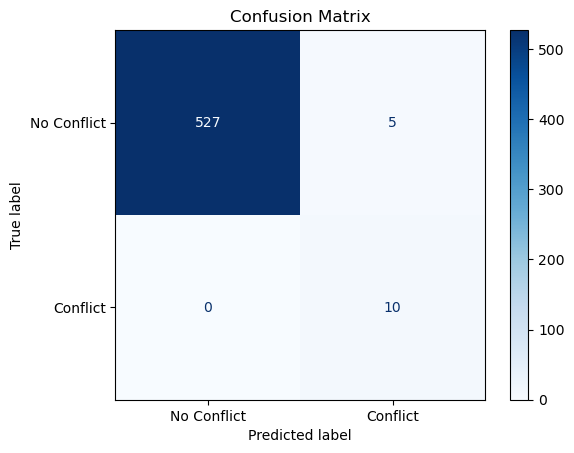


Model training complete.

Predicting test scenarios:

Prediction Results Table:


/Users/magdalenacullen/ITBA/intercambio/project-final/EDAN70-Autonomous-Driving-Conflict-Analysis/all_test_predictions.csv

,Scenario ID,Risk Level,Confidence
0,4338,LOW,1.000000
1,4339,LOW,0.997379
2,4340,LOW,1.000000
3,4341,LOW,0.999999
4,4342,LOW,0.999216
...,...,...,...
672,5329,LOW,0.970713
673,5330,LOW,1.000000
674,5331,LOW,0.999995
675,5333,LOW,1.000000


In [57]:
from IPython.lib.display import FileLink
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd

print("\nSplitting data into training and testing sets...")
available_scenarios = []
for _, case in intersection_cases.iterrows():
    scenario_id = case['log_id']
    filename = get_scenario_filename(scenario_id, root_av)
    if filename is not None:
        available_scenarios.append(case)

print(f"\nTotal available scenarios: {len(available_scenarios)}")

# Split data into training and testing sets (80% training, 20% testing)
split_idx = int(0.8 * len(available_scenarios))
train_data = pd.DataFrame(available_scenarios[:split_idx])  # 80% for training
test_data = pd.DataFrame(available_scenarios[split_idx:])   # 20% for testing

print(f"Using {len(train_data)} scenarios for training")
print(f"Using {len(test_data)} scenarios for testing")

# Train the logistic regression model
print("\nTraining logistic regression model...")
model, scaler = train_logistic_regression(train_data, root_av)
print("\nModel training complete.")

# Test predictions on 20% of the data
print("\nPredicting test scenarios:")

scenario_ids = []
risk_levels = []
confidences = []

for _, case in test_data.iterrows():
    scenario_id = case['log_id']
    test_scenario = analyze_intersection_scenario(scenario_id, root_av)

    if test_scenario:
        try:
            initial_features, _ = prepare_logistic_regression_data(test_scenario)
            initial_features_scaled = scaler.transform(initial_features.reshape(1, -1))
            prediction = model.predict(initial_features_scaled)[0]
            probabilities = model.predict_proba(initial_features_scaled)[0]
            max_probability = np.max(probabilities)
            risk_level = ['LOW', 'MEDIUM', 'HIGH'][prediction]

            scenario_ids.append(scenario_id)
            risk_levels.append(risk_level)
            confidences.append(max_probability)
        except Exception as e:
            prediction, probability = predict_collision(None, None, test_scenario)
            if prediction is not None:
                risk_level = ['LOW', 'MEDIUM', 'HIGH'][prediction]
                scenario_ids.append(scenario_id)
                risk_levels.append(risk_level)
                confidences.append(probability)
    # If test_scenario is None, skip

# Create DataFrame
results_df = pd.DataFrame({
    'Scenario ID': scenario_ids,
    'Risk Level': risk_levels,
    'Confidence': confidences
})


results_df.to_csv('all_test_predictions.csv', index=False)
print("\nPrediction Results Table:")
display(FileLink('all_test_predictions.csv'))
results_df